# Project Description

My project goal was to discover if there is any correlation between restaurant inspection score and the weather on the day of corresponding inspections. I hoped to see if restaurant inspection scores can be correlated with any aspect of weather provided by NOAA.  
My sources contained data on food inspection score and date, restaurant name and types, and data for many different aspects of weather including wind speeds, temperature, precipitation, and date.
My analysis compared individual restaurant inspections against average high temperature readings for the day of the inspection.

# Datasources

Data on restaurants was downloadable from data.world, courtesy of user “ssaudz” (https://data.world/ssaudz/1000-austin-restaurants). Per ssaudz’s description, the data was collected from Yelp. The biggest challenge with this data was processing the ‘Category’ and ‘Sub Category’ data after I had decided to treat them as equivalent information and to structure ‘Type’ as an entity separate from ‘Restaurant’. I discuss my resolution to the ‘Type’ issue below in the “Challenges” section of this report.

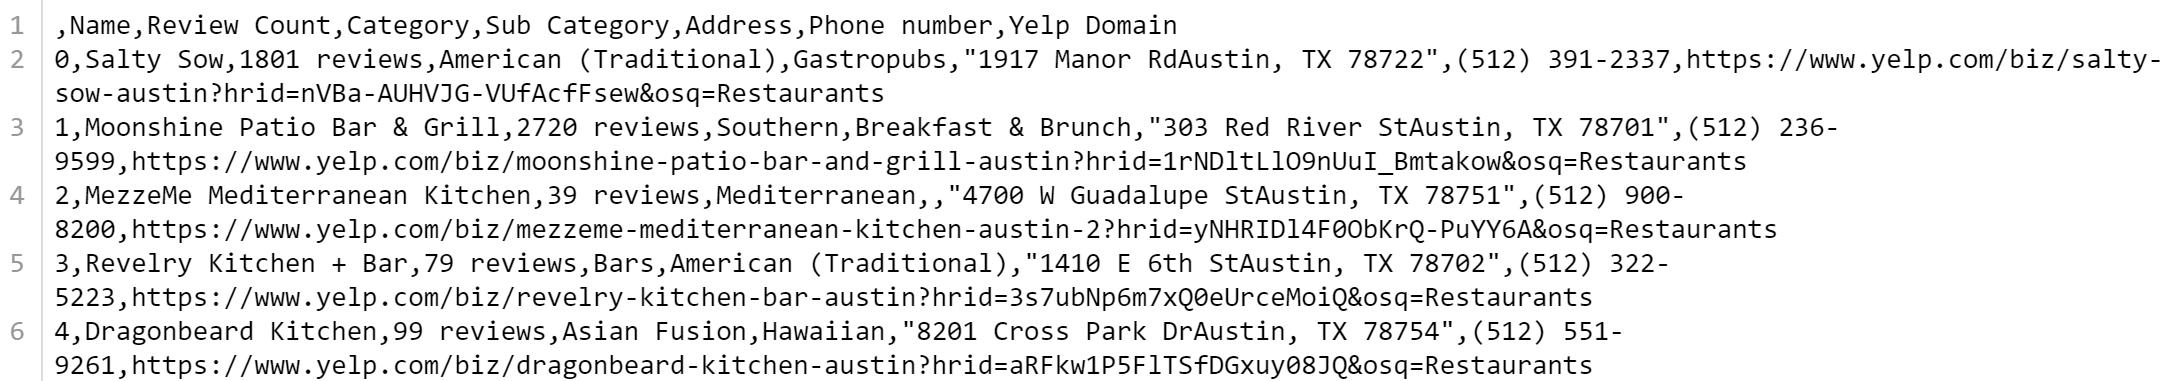

Data on inspections was retrieved through the City of Austin’s open data website (https://data.austintexas.gov/Health-and-Community-Services/Food-Establishment-Inspection-Scores/ecmv-9xxi). This data was fairly manageable especially considering that I did not need to deal with the ‘Address’ field. The biggest challenges with this data were processing the dates as they were not in proper date format, and replacing the restaurant 'Name' field with the correct ‘id’ from the ‘restaurants’ table.

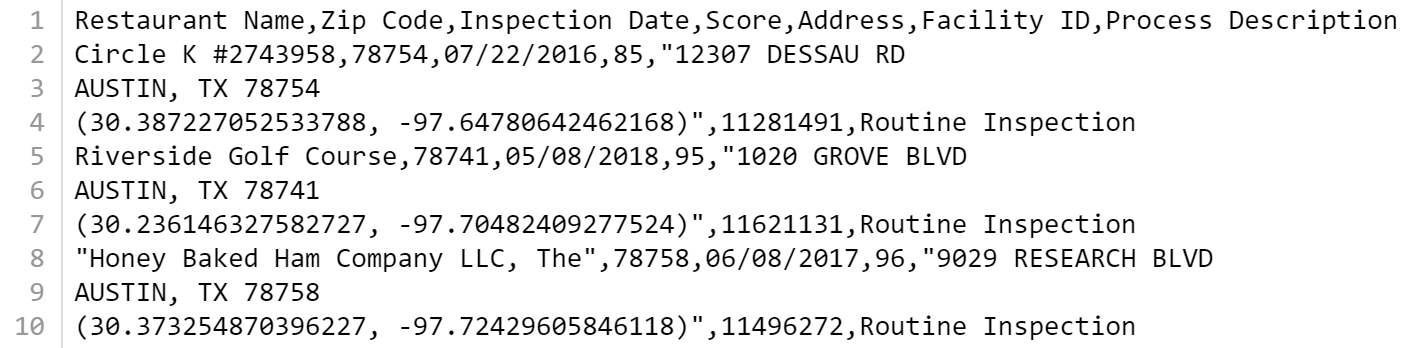

Data on weather unfortunately involved some manual components as data is available only by request through NOAA’s Climate Data Online portal (https://www.ncdc.noaa.gov/cdo-web/). Once this request is made and the order is filled it is sent to the user’s email as a CSV at which point it could be downloaded for processing. The other tedious aspect of the weather data was mapping the weather codes to human-readable values. To do this I had to find the data mapping document for the type of reports I had been served. I decided to implement the mapping through parameters in SQL as opposed to a separate mapping dictionary because it was a single-use mapping and could be referenced via the SQL query. The final challenges with this data were determining the data types of each field as well as which fields were actually populated in the data. I resolved this by using control logic to determine data types and frequency of use and then converting and inserting the data based on my findings.

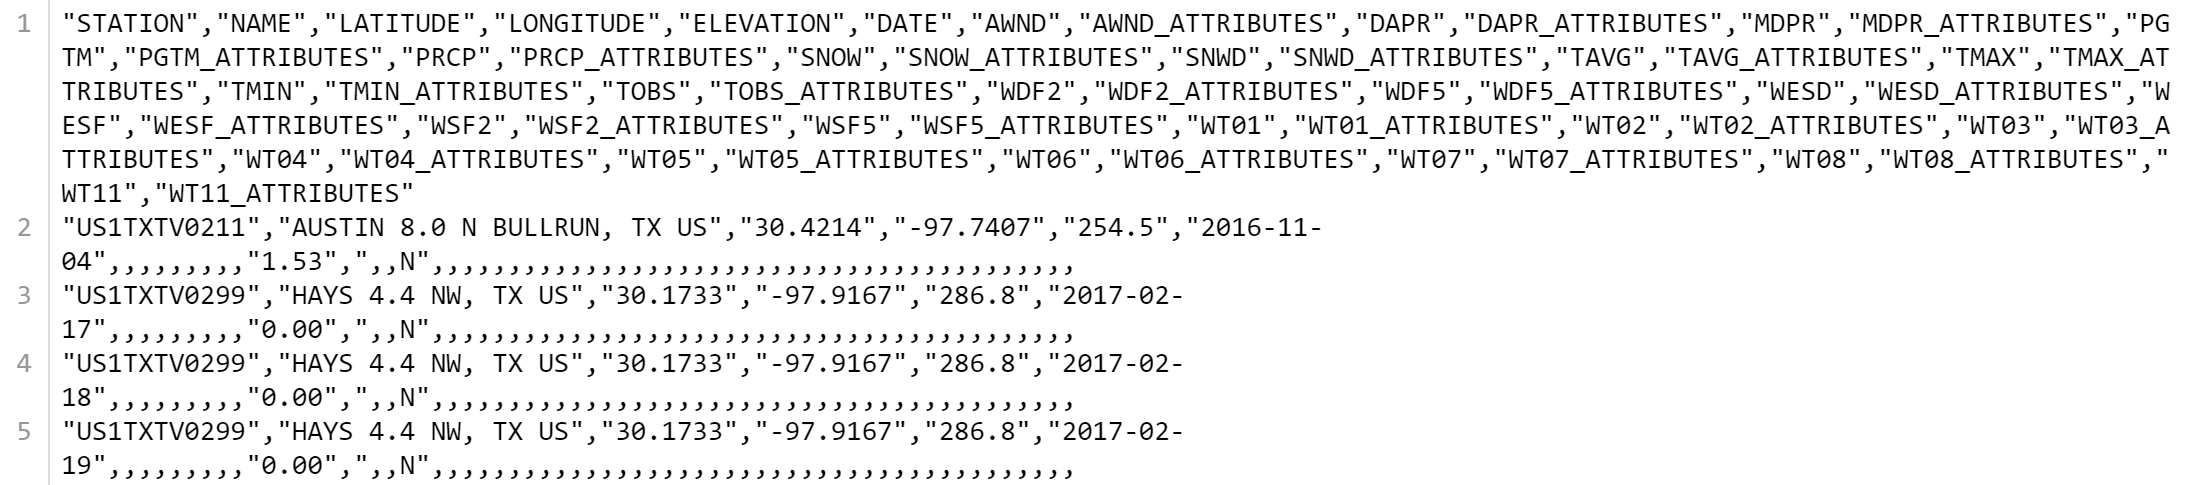

# Workflow

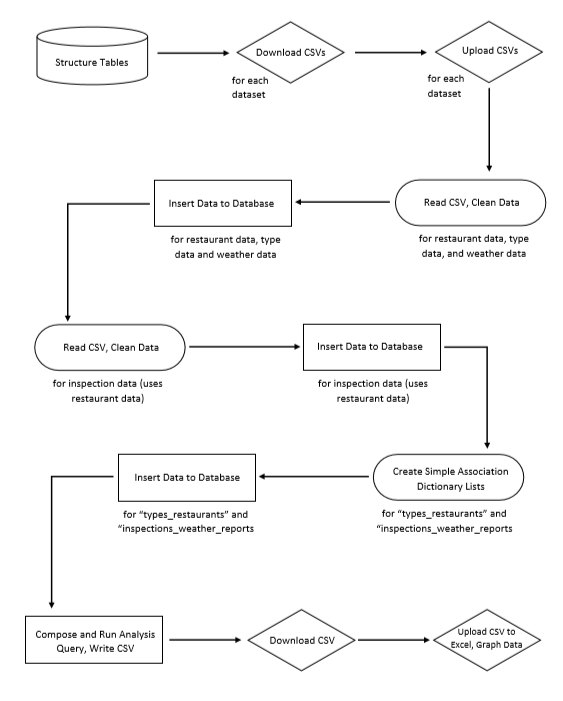

# Database Design

My database design is fairly straightforward with the exception of the representation of the ‘Day’ entity. Because the date is not a natural attribute of an inspection, I represented it as an entity which ‘Inspection’ belongs to. Likewise the date is not a natural attribute of the weather and I represented ‘Weather Report’ as an entity which ‘Day’ belongs to. Ultimately however I decided that it would be more natural for table structure and manipulation to make date an attribute of each type of data and represent this relationship via a simple association table as if they had a direct many-to-many relationship while in reality these entities are related through the concept of a day.  
The other significant choice that I had to make was whether to represent restaurant 'type' and 'sub-type' as attributes of 'Restaurant' or in another way. Ultimately I decided to treat 'types' and 'sub-types' both as instances of a 'Type' entity which I describe in more detail in the "Challenges" section of this report.

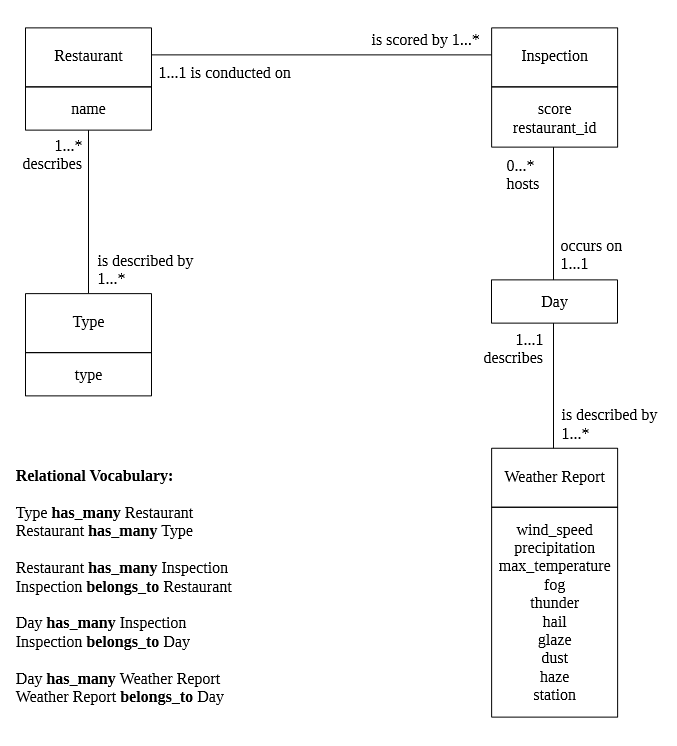

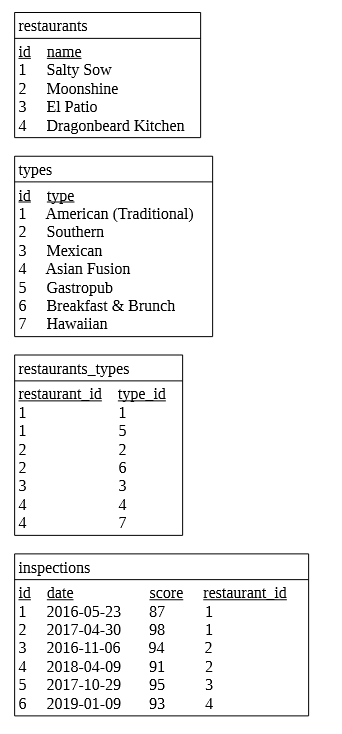

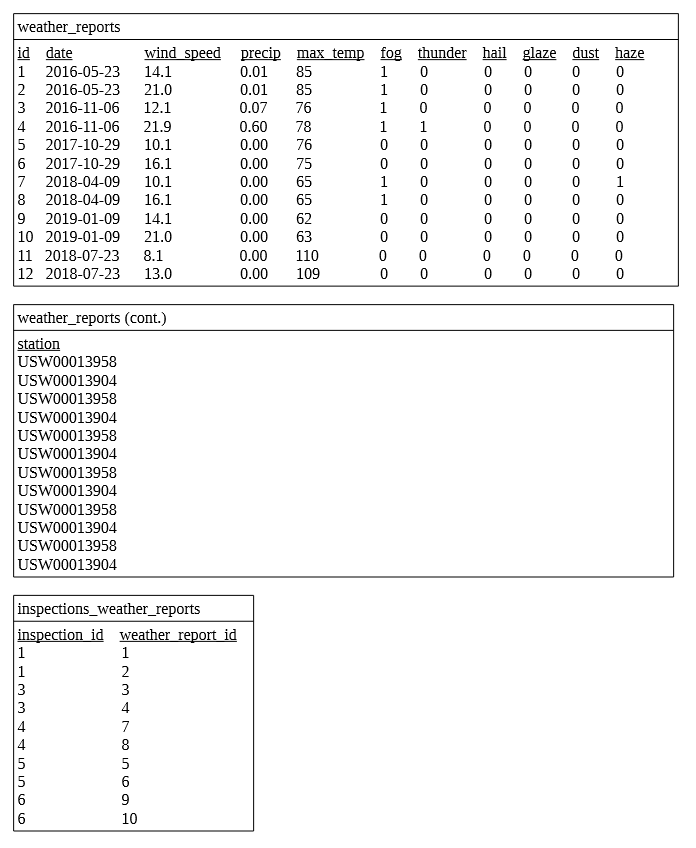

# Data Processing Code

In [1]:
# import libraries
import csv
import pymysql
from datetime import datetime

# connect to database
connection = pymysql.connect(host="mariadb",           
                             user="root",             
                             passwd="",   
                             db="project",
                             autocommit=True,
                             cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

In [2]:
# RESTAURANTS insertion

# empty table to insert from a known state.
empty_tables_query = "TRUNCATE restaurants;"
cursor.execute(empty_tables_query)

with open('Austin_1000_Restaurants.csv') as csvfile :
    myCSVReader = csv.DictReader(csvfile)

    # sql INSERT statement using table fields and their corresponding CSV headers
    sql = """
        INSERT INTO restaurants(name)
        VALUE (%(Name)s)
    """

    # iteration through CSV, executing sql INSERT statement for each row
    for row in myCSVReader :
        cursor.execute(sql, row)
        
print("finished restaurants insertion")

finished restaurants insertion


In [3]:
# TYPES insertion

# empty table to insert from a known state
empty_tables_query = "TRUNCATE types;"
cursor.execute(empty_tables_query)

with open('Austin_1000_Restaurants.csv') as csvfile :
    my_dict_reader = csv.DictReader(csvfile)
    
    insert_types_query = """
        INSERT INTO types(type)
        VALUE (%(type)s)
    """
    
    types = []    
    # read through restaurants rows, for every row...
    # if "Category" or "Sub Category" not in types list, add to types list
    for row in my_dict_reader :
        types.append(row['Category'])
        types.append(row['Sub Category'])

# reset types to a list of only unique types
types = list(set(types))

# make list of types into list of type dicts (unless no "type")
types_dict_list = []
for item in types :
    if item != '' :
        types_row = {'type': item}
        types_dict_list.append(types_row)

# run sql insert query over dict list
for row in types_dict_list :
    cursor.execute(insert_types_query, row)
    
print("finished types insertion")

finished types insertion


In [4]:
# WEATHER_REPORTS INSERTION

# empty tables to insert from a known state
empty_tables_query = "TRUNCATE weather_reports;"
cursor.execute(empty_tables_query)

with open('weather_data.csv') as csvfile :
    myCSVReader = csv.DictReader(csvfile)
    
    # sql INSERT statement using table fields and their corresponding CSV headers
    insert_reports_query = """
        INSERT INTO weather_reports(date,wind_speed,precipitation,temperature,fog,thunder,hail,glaze,dust,haze,station_id)
        VALUE (%(DATE)s,%(WSF2)s,%(PRCP)s,%(TMAX)s,%(WT01)s,%(WT03)s,%(WT05)s,%(WT06)s,%(WT07)s,%(WT08)s,%(STATION)s)
    """
    
    # iteration through CSV, executing sql INSERT statement for each row
    for row in myCSVReader :
        
        # convert each column's values to proper type
        if row['WSF2'] == '' :
            row['WSF2'] = 0
        else :
            row['WSF2'] = float(row['WSF2'])
        if row['PRCP'] == '' :
            row['PRCP'] = 0
        else :
            row['PRCP'] = float(row['PRCP'])
        if row['WT01'] == '' :
            row['WT01'] = False
        else :
            row['WT01'] = True
        if row['WT03'] == '' :
            row['WT03'] = False
        else :
            row['WT03'] = True
        if row['WT05'] == '' :
            row['WT05'] = False
        else :
            row['WT05'] = True
        if row['WT06'] == '' :
            row['WT06'] = False
        else :
            row['WT06'] = True
        if row['WT07'] == '' :
            row['WT07'] = False
        else :
            row['WT07'] = True
        if row['WT08'] == '' :
            row['WT08'] = False
        else :
            row['WT08'] = True
        
        # run insert statment
        if row['TMAX'] != '':
            row['TMAX'] = float(row['TMAX'])
            cursor.execute(insert_reports_query, row)
            
print("finished weather_reports insertion")

finished weather_reports insertion


In [5]:
# INSPECTIONS insertion

# empty tables to insert from a known state.
empty_tables_query = "TRUNCATE inspections;"
cursor.execute(empty_tables_query)

with open('Food_Establishment_Inspection_Scores.csv') as csvfile :
    myCSVReader = csv.DictReader(csvfile)
    
    insert_inspection_query = """
        INSERT INTO inspections(date, score, restaurant_id)
        VALUE (%(inspection_date)s, %(score)s, %(restaurant_id)s)
    """
    
    select_restaurant_id_query = """
        SELECT id
        FROM restaurants
        WHERE name = %(Restaurant Name)s
    """
    
    for row in myCSVReader :
        
        # Transform 'Inspection Date' column
        incoming_date = row['Inspection Date']
        incoming_format = "%m/%d/%Y"
        inspection_date = datetime.strptime(incoming_date, incoming_format)
        
        # Search the "restaurants" table for matching restaurants and set as the var 'result'
        cursor.execute(select_restaurant_id_query, row)
        result = cursor.fetchone()
        
        # If result returns a value, set that value as the variable 'restaurant_id' for use in the param_dict 
        # and insert the inspection data (via the above sql INSERT statement)
        if result != None :
            restaurant_id = result['id']
            
            # Create param_dict and execute query
            param_dict = {'inspection_date': inspection_date, 'score': row['Score'], 'restaurant_id': restaurant_id}
            cursor.execute(insert_inspection_query, param_dict)
            
print("finished inspections insertion")

finished inspections insertion


In [6]:
# RESTAURANTS_TYPES association table

# empty tables to run from a known state.
empty_tables_query = "TRUNCATE restaurants_types;"
cursor.execute(empty_tables_query)

type_matching_query = """
    SELECT types.id
    FROM types
    WHERE types.type = %(type_entry)s
"""

select_restaurants_query = """
    SELECT restaurants.id
    FROM restaurants
    WHERE restaurants.name = %(Name)s
"""

insert_restaurants_types_query = """
    INSERT INTO restaurants_types (restaurant_id,type_id)
    VALUES (%(restaurant_id)s, %(type_id)s)
"""

with open('Austin_1000_Restaurants.csv') as csvfile :
    my_csv_reader = csv.DictReader(csvfile)
    
    for row in my_csv_reader :
        # get restaurant id based on name using restaurants query
        cursor.execute(select_restaurants_query, row)
        restaurant_id = cursor.fetchone()
        
        # get type and create entry for each type
        cursor.execute(type_matching_query, {'type_entry': row['Category']})        
        type_id = cursor.fetchone()
        if type_id != None :
            param_dict = {'restaurant_id': restaurant_id['id'], 'type_id': type_id['id']}
            cursor.execute(insert_restaurants_types_query, param_dict)
        
        # get sub-type and create entry for each sub-type as type
        cursor.execute(type_matching_query, {'type_entry': row['Sub Category']})
        type_id = cursor.fetchone()
        if type_id != None :
            param_dict = {'restaurant_id': restaurant_id['id'], 'type_id': type_id['id']}
            cursor.execute(insert_restaurants_types_query, param_dict)
            
print("finished restaurants_types insertion")

finished restaurants_types insertion


In [7]:
# INSPECTIONS_WEATHER_REPORTS association table

# empty tables to run from a known state.
empty_tables_query = "TRUNCATE inspections_weather_reports;"
cursor.execute(empty_tables_query)

with open('inspections_weather_reports.csv', 'w') as csvfile :
    myCSVWriter = csv.DictWriter(csvfile, fieldnames=['inspection_id','weather_report_id'])

    sql = """
        SELECT weather_reports.id AS weather_report_id, inspections.id AS inspection_id
        FROM weather_reports
            JOIN inspections
                ON inspections.date = weather_reports.date
    """
    
    cursor.execute(sql)
    results = cursor.fetchall()
    
    myCSVWriter.writeheader()
    
    for row in results :
        myCSVWriter.writerow(row)
        
print("finished writing inspections_weather_reports.csv")
        
with open('inspections_weather_reports.csv') as csvfile :
    myCSVReader = csv.DictReader(csvfile)
    
    sql = """
        INSERT INTO inspections_weather_reports (inspection_id,weather_report_id)
        VALUE (%(inspection_id)s,%(weather_report_id)s)
    """
    
    for row in myCSVReader :
        cursor.execute(sql, row)
    
print("finished inspections_weather_reports insertion")

finished writing inspections_weather_reports.csv
finished inspections_weather_reports insertion


In [8]:
with open('temperatures_scores.csv', 'w') as csvfile :
    myCSVWriter = csv.DictWriter(csvfile, fieldnames=['id','temperature','score'])
    
    analysis_query1 = """
        SELECT inspections.id, AVG(weather_reports.temperature) as temperature, inspections.score
        FROM inspections
            JOIN weather_reports
                ON weather_reports.date = inspections.date
        GROUP BY inspections.id
    """
    
    cursor.execute(analysis_query1)
    results = cursor.fetchall()
    
    myCSVWriter.writeheader()
    for row in results :
        myCSVWriter.writerow(row)
        
print("finished writing temperatures_scores.csv")

finished writing temperatures_scores.csv


# Analysis

My analysis, comparing the mean of observed high temperatures in Austin weather stations against the inspection scores of inspections which occurred on those days, seems to show no correlation. The temperature on the day that an inspection occurs seems to have no impact on the score of that inspection.

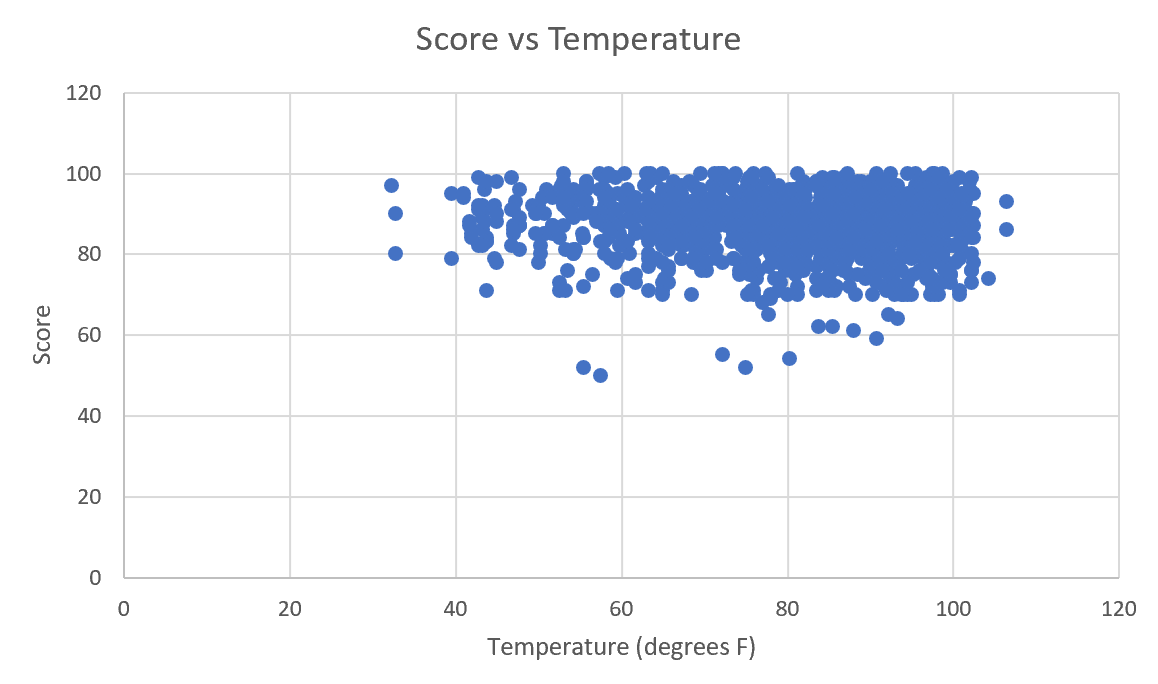

# Challenges

The most challenging aspect of my data wrangling workflow was restructuring the type data for restaurants given how it was provided.  
As provided, restaurant type information was in two separate columns (‘Category’ and ‘Sub Category’)  as part of the CSV with all restaurant data. Due to the lack of a definition for the relationship between ‘Category’ and ‘Sub Category’, I decided that it would be best to treat both column values as an equivalent ‘Type’ entity.  
From this decision I reasoned that a ‘Restaurant’ could have multiple ‘types’ and that each ‘Type’ could potentially apply to many different restaurants and would thus need a simple association table to represent this information.  
At this point, using python, I had to read the restaurants CSV for ‘type’ values, create a unique list of dictionaries, and upload that list of dictionaries into the MySQL table I created for ‘type’ information. Finally, this allowed me to create the ‘restaurants_types’ table using the names and ids from ‘restaurants’ and the types and ids from ‘types’.

# Analysis Tool Learning Process

For my analysis I used Excel. It did not take long to figure out how to import my analysis data into Excel as we had gone over that process in class. Likewise, I was able to select the two columns that I desired to plot and create a basic scatter plot fairly easily after having learned this technique in class and practiced it for an assignment. The last aspect of learning my analysis tool was to figure out how to properly edit my plot’s design elements including titling. This I accomplished by an internet search which displayed the directions for finding the relevant menu in the program.